In [457]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
from tqdm import tqdm
import time
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import classification_report,confusion_matrix
from warnings import filterwarnings

filterwarnings("ignore")

# DATA PREPROCESSING

In [3]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 150

print("Training data is being uploaded.")
for i in labels:
    folderPath = os.path.join('C:\\Users\\melih\\Desktop\\PROJE DOSYALARI\\Brain Tumor Classification\\Data','Training',i)
    for j in tqdm(os.listdir(folderPath),ncols=100,desc = i + "data upload"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        time.sleep(0.001)
print("Training data has been successfully uploaded.")

print("-----------------------------------------------")

print("Testing data is being uploaded.")        
for i in labels:
    folderPath = os.path.join('C:\\Users\\melih\\Desktop\\PROJE DOSYALARI\\Brain Tumor Classification\\Data','Testing',i)
    for j in tqdm(os.listdir(folderPath),ncols=100,desc = i + "data upload"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
print("Testing data has been successfully uploaded.")


Training data is being uploaded.


pituitary_tumordata upload: 100%|████████████████████████████████| 827/827 [00:03<00:00, 241.26it/s]


Training data has been successfully uploaded.
-----------------------------------------------
Testing data is being uploaded.


pituitary_tumordata upload: 100%|██████████████████████████████████| 74/74 [00:00<00:00, 225.96it/s]

Testing data has been successfully uploaded.


In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [6]:
X_train_copy = np.copy(X_train)
y_train_copy = np.copy(y_train)

In [173]:
y_test

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [177]:
y_test_label=np.array([labels[np.argmax(row)] for row in y_test])
y_train_label = np.array([labels[np.argmax(row)] for row in y_train])

Text(0.34, 0.96, 'Distribution of Training/Testing Data')

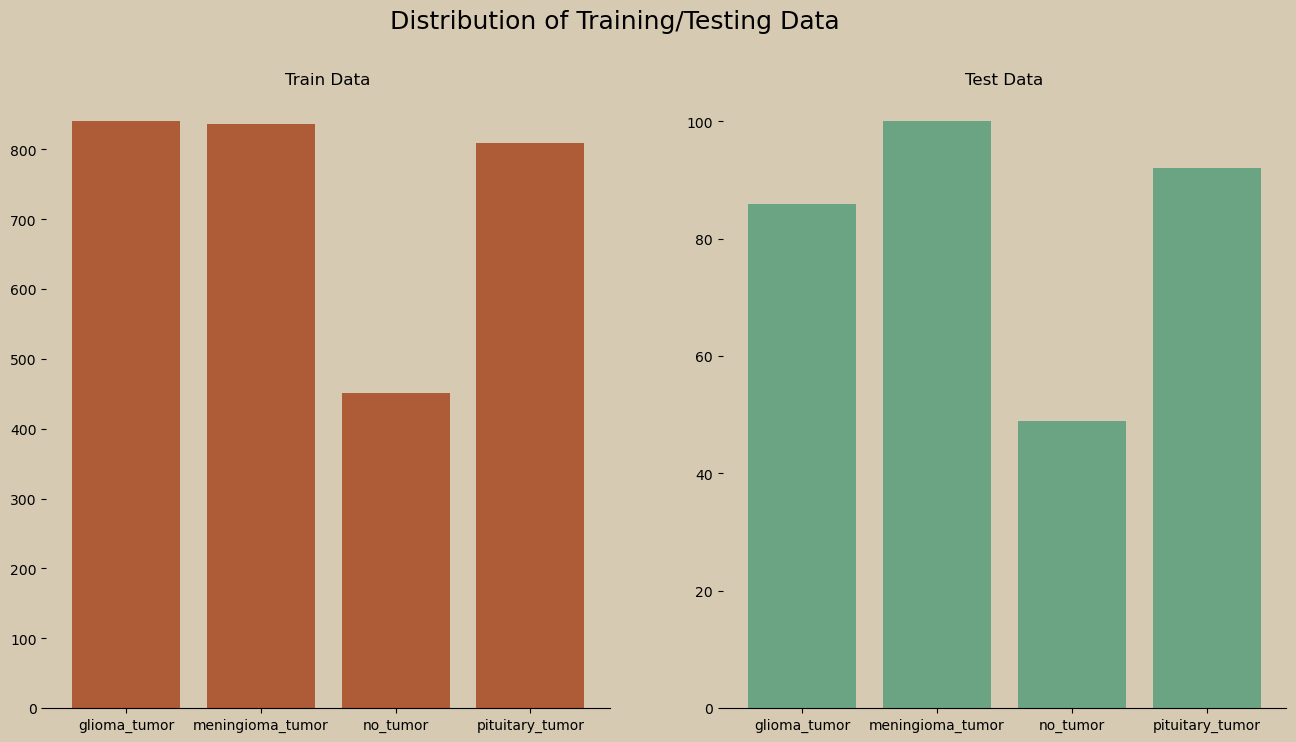

In [313]:
unique_test, counts_test = np.unique(y_test_label, return_counts=True)
unique_train, counts_train = np.unique(y_train_label, return_counts=True)
c=["#740000","#d7de00","#0dd7bb","#a26900"]
fig,ax=plt.subplots(1,2,figsize=(16,8))
fig.set_facecolor("#d6cab2")
sns.despine(left=True)

ax[0].bar(height = counts_train,x=unique_train,color="#ae5b37")
ax[0].set_facecolor("#d6cab2")
ax[0].set_title("Train Data")

ax[1].bar(height = counts_test,x=unique_test,color="#6ba482")
ax[1].set_facecolor("#d6cab2")
ax[1].set_title("Test Data")


#fig.suptitle("Distribution of Training/Testing Data")
fig.text(s='Distribution of Training/Testing Data',size=18,y=0.96,x=0.34)

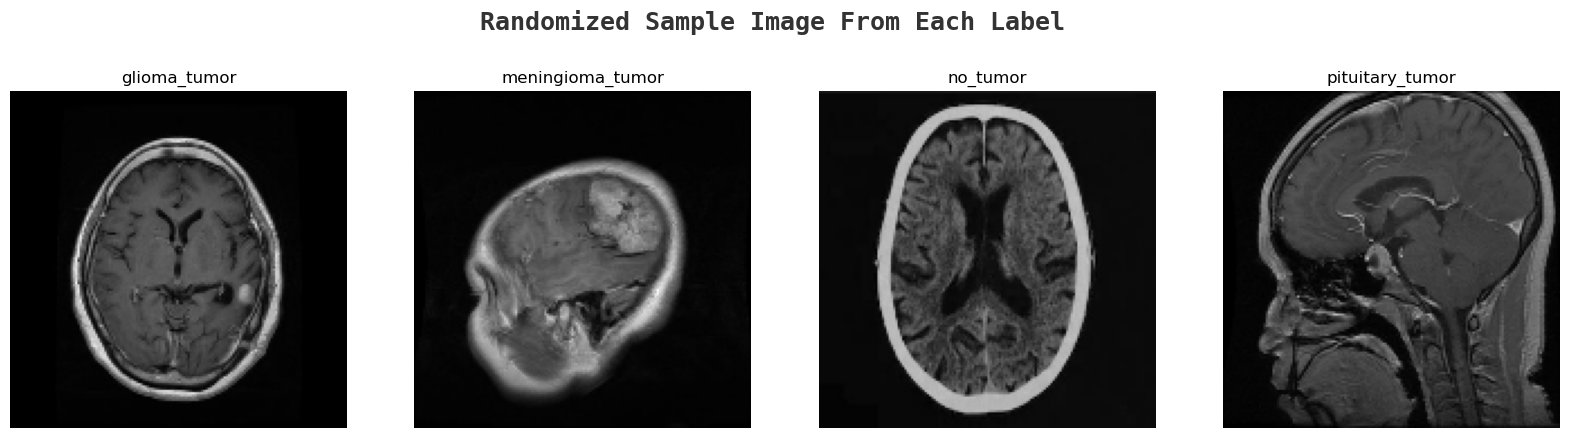

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Randomized Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.61,x=0.36,alpha=0.8)

for i in labels:
    while True :
        index = np.random.choice(np.arange(0,3265))
        if y_train_copy[index]==i:
            ax[k].imshow(X_train_copy[index])
            ax[k].set_title(y_train_copy[index])
            ax[k].axis('off')
            k+=1
            break

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=1549)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1549)

In [10]:
y_train_new = []

for i in y_train:
    y_train_new.append(labels.index(i))
    

y_train = tf.keras.utils.to_categorical(y_train_new)

In [11]:
y_train_new[:5],y_train[:5] 

([3, 0, 1, 1, 1],
 array([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]]))

In [12]:
y_test_new = []

for i in y_test:
    y_test_new.append(labels.index(i))
    
y_test = tf.keras.utils.to_categorical(y_test_new)

# MODEL

In [77]:
base_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [78]:
model = Sequential([
    base_model,  
    GlobalAveragePooling2D(),
    Dropout(rate=0.5),
    Dense(4, activation='softmax')  
])

In [79]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 5, 5, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [83]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [85]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [87]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=16,
                   callbacks=[early_stop])

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 131s 599ms/step - accuracy: 0.7212 - loss: 0.6866 - val_accuracy: 0.7415 - val_loss: 0.8272
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 95s 572ms/step - accuracy: 0.9048 - loss: 0.2827 - val_accuracy: 0.8571 - val_loss: 0.4705
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 98s 592ms/step - accuracy: 0.9296 - loss: 0.2117 - val_accuracy: 0.8163 - val_loss: 0.6187
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 89s 537ms/step - accuracy: 0.9479 - loss: 0.1567 - val_accuracy: 0.9354 - val_loss: 0.1728
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 548ms/step - accuracy: 0.9752 - loss: 0.0817 - val_accuracy: 0.9558 - val_loss: 0.1283
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 96s 579ms/step - accuracy: 0.9666 - loss: 0.1107 - val_accuracy: 0.8980 - val_loss: 0.3673
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 96s 580ms/step - accuracy: 0.9766 - loss: 0.0812 - val_accuracy: 0.9592 - val_loss: 0.1407
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 95s 570ms/step - accuracy: 0.9734 - loss: 

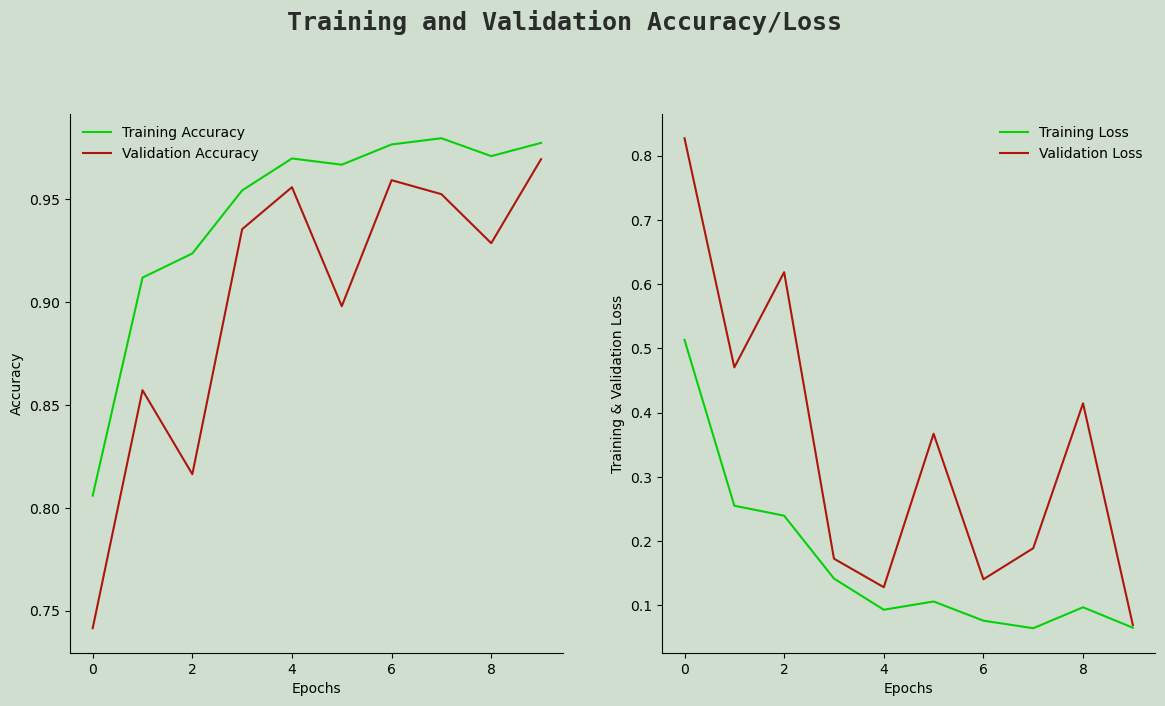

In [95]:
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
fig.set_facecolor("#cfdecf")

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc,color="#05d108",label = 'Training Accuracy')
ax[0].plot(epochs, val_acc,color="#ae150b", label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_facecolor("#cfdecf")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,color="#05d108", label ='Training Loss')
ax[1].plot(epochs, val_loss, color="#ae150b",label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_facecolor("#cfdecf")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [141]:
pred = np.argmax(model.predict(X_test),axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step


In [157]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        86
           1       0.97      0.91      0.94       100
           2       0.89      1.00      0.94        49
           3       0.96      1.00      0.98        92

    accuracy                           0.95       327
   macro avg       0.95      0.96      0.95       327
weighted avg       0.96      0.95      0.95       327



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

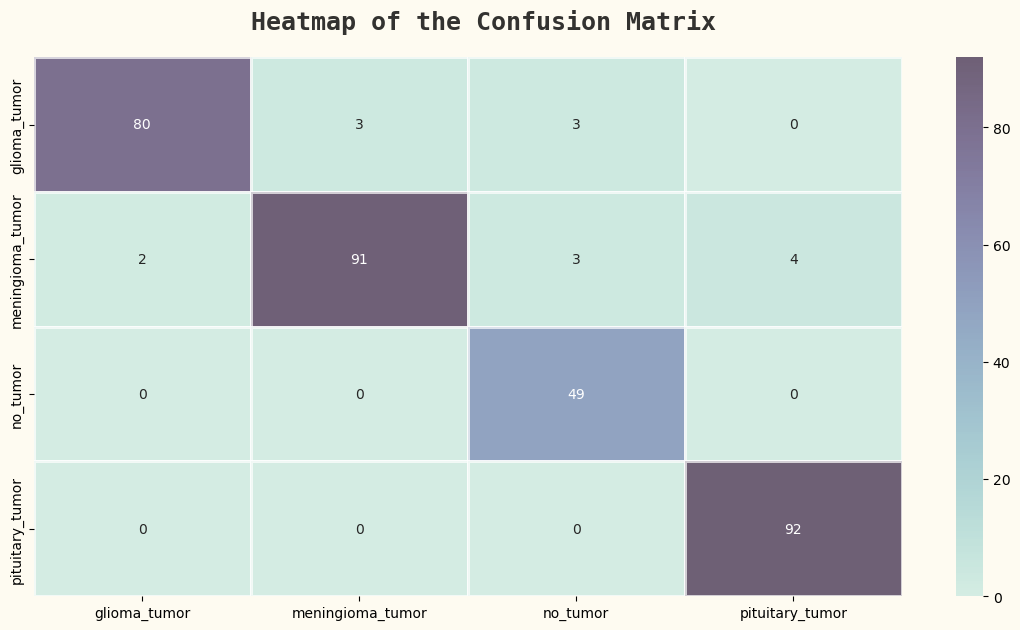

In [143]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
palette=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,cmap=palette,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.set_facecolor("#fefbf1")
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

Text(-360, -300, 'Prediction of Tumor Types')

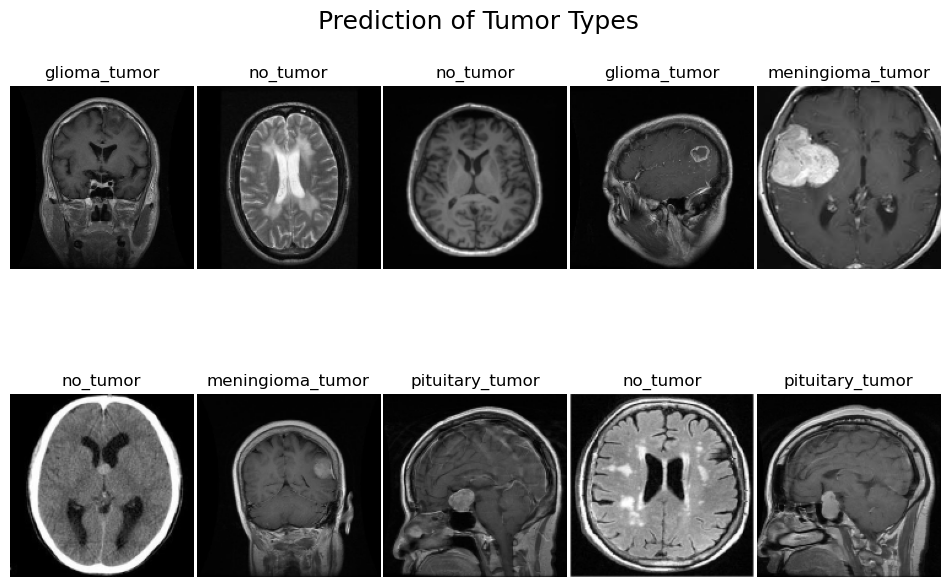

In [455]:
pred_label=np.array([labels[row] for row in pred])
plt.figure(figsize=(12,8))
c=1
for index,image in enumerate(X_test[:10]):
    plt.subplot(2,5,c)
    plt.imshow(image)
    plt.title(pred_label[index])
    plt.axis('off')
    c+=1     
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.text(s='Prediction of Tumor Types',size=18,y=-300,x=-360)